# In this notebook, i will perfotm K-Means Clustering and Principal Component Analysis(PCA) on Mall Customer Segmentation dataset. The goal is to understand customer behavior.

# Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Importin the dataset

In [2]:
mall = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv', index_col = 'CustomerID')
mall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [3]:
mall.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [4]:
mall.shape

(200, 4)

In [5]:
mall.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


# Exploring the data

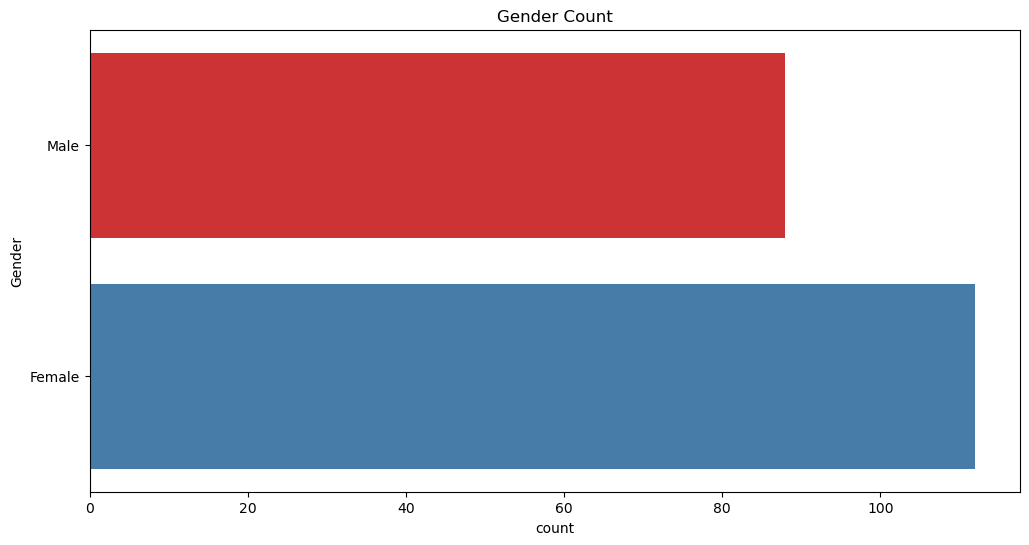

In [6]:
plt.figure(figsize=(12,6))
sns.countplot(y = 'Gender', data = mall, palette = 'Set1')
plt.title('Gender Count');

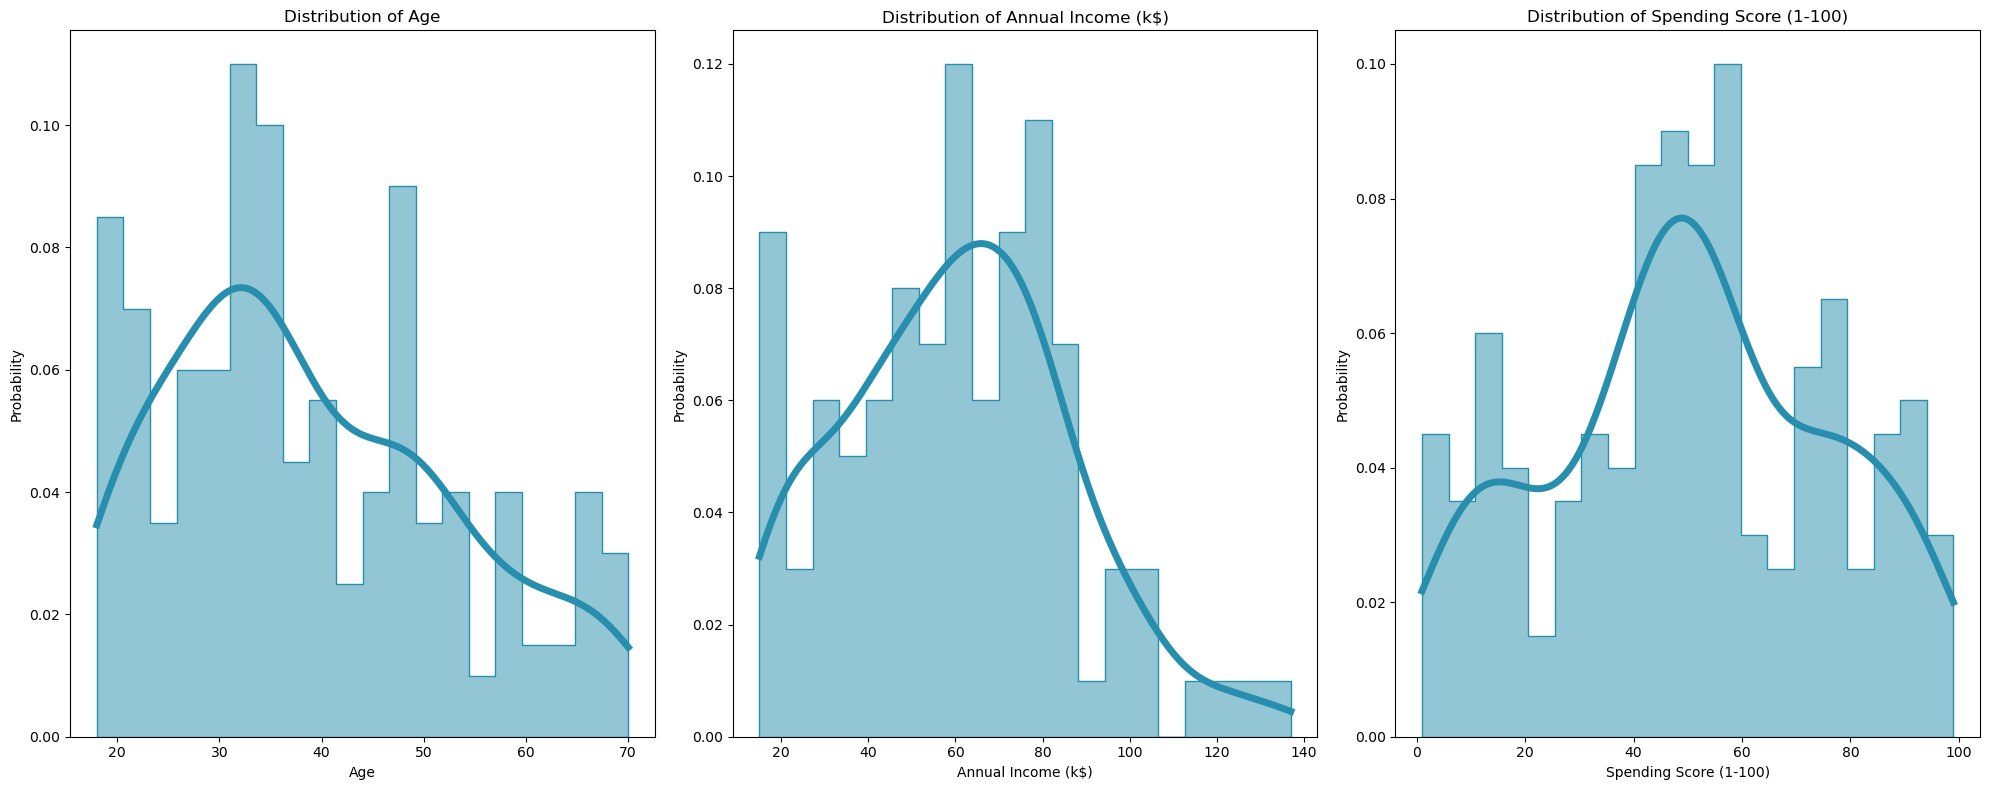

In [7]:
plt.figure(figsize=(20,8))
for i, j in enumerate(mall.columns[1:]):
    ax = plt.subplot(1, 3, i+1)
    sns.histplot(x = j, data = mall, bins = 20, kde = True, stat = 'probability',
                 fill = True, color = '#288ead', element = 'step',
                 line_kws = {'lw': 5})
    plt.title('Distribution of {}'.format(j))
plt.tight_layout()

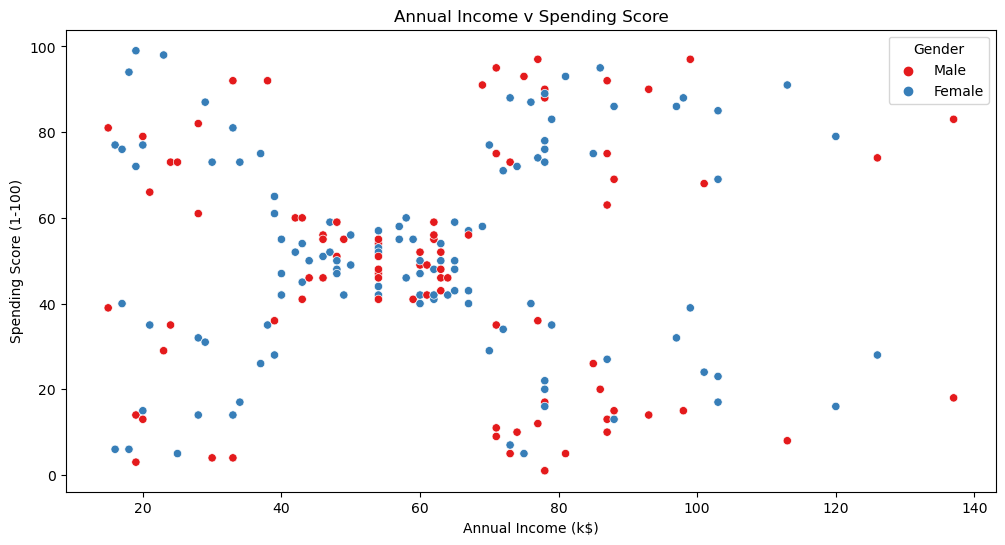

In [8]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = 'Annual Income (k$)', y = 'Spending Score (1-100)', data = mall, 
                hue = 'Gender', palette = 'Set1');
plt.title('Annual Income v Spending Score');

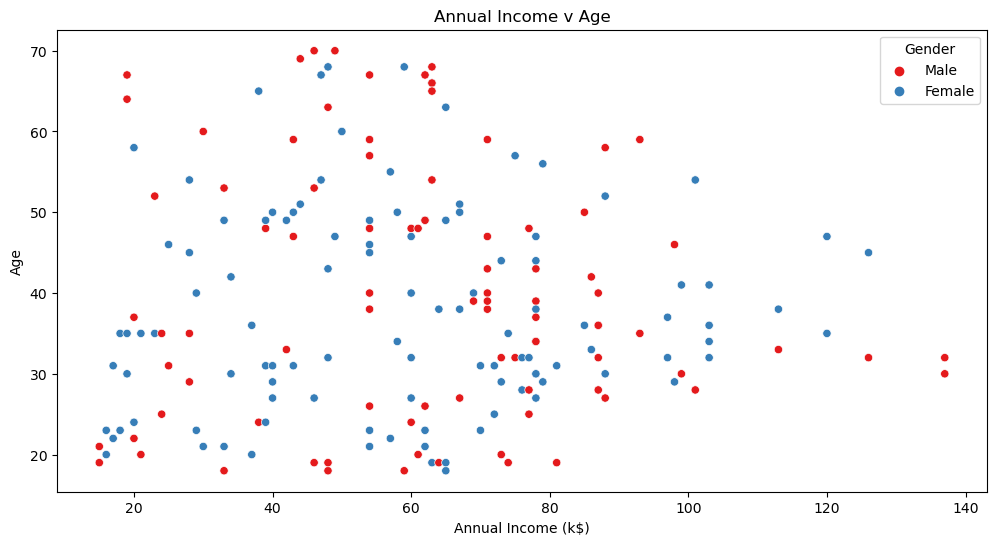

In [9]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = 'Annual Income (k$)', y = 'Age', data = mall, 
                hue = 'Gender', palette = 'Set1');
plt.title('Annual Income v Age');

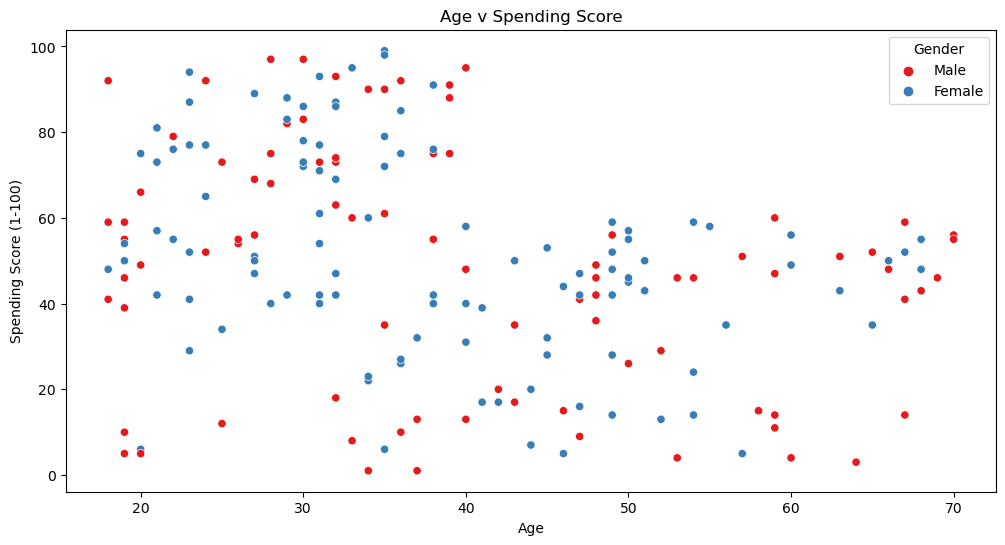

In [10]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = 'Age', y = 'Spending Score (1-100)', data = mall, 
                hue = 'Gender', palette = 'Set1');
plt.title('Age v Spending Score');

# Preparing data to build the model

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = mall[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values
X1 = mall[['Age', 'Spending Score (1-100)']].values
X2 = mall[['Age', 'Annual Income (k$)']].values
X3 = mall[['Spending Score (1-100)', 'Annual Income (k$)']].values

#Standardizing the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X1 = scaler.fit_transform(X1)
X2 = scaler.fit_transform(X2)
X3 = scaler.fit_transform(X3)

#Creating a dictionary containing kmeans model arguments 
kmeans_kwargs = {
    'init': 'k-means++',
    'n_init': 20,
    'max_iter': 300,
    'random_state': 40
}

# Defining a function for elbow plots

In [12]:
from yellowbrick.cluster import KElbowVisualizer

def elbow_plot(x):
    sns.set_style('ticks')
    plt.figure(figsize=(12,6))
    
    visualizer = KElbowVisualizer(KMeans(**kmeans_kwargs), k=(2,10))
    visualizer.fit(x)
    visualizer.show();

# Defining a function for the K-Means model and associated attributes

In [13]:
def kmeans_model(k, x):
    model = KMeans(k, **kmeans_kwargs)
    model.fit(x)
    labels = model.labels_
    centroids = model.cluster_centers_
    return model, labels, centroids

# Defining a function to plot the clusters 

In [14]:
def plot_clusters(x, h, model, labels, centroids):
    #Creating a meshgrid for visualization
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    
    #Plotting the clusters using the meshgrid
    sns.set_style('ticks')
    plt.clf()
    plt.figure(figsize=(12, 6))

    plt.imshow(z, interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = 'Pastel1', aspect = 'auto',
           origin = 'lower')

    sns.scatterplot(x = x[:, 0], y = x[:, 1], 
                hue = labels, palette = 'tab10', s = 100)
    plt.scatter(x = centroids[:, 0] , y = centroids[:, 1], 
                s = 100, c = 'black', alpha = 0.8, marker = 'X')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()

# Clustering for Age and Spending Score

> # 1. Elbow Plot

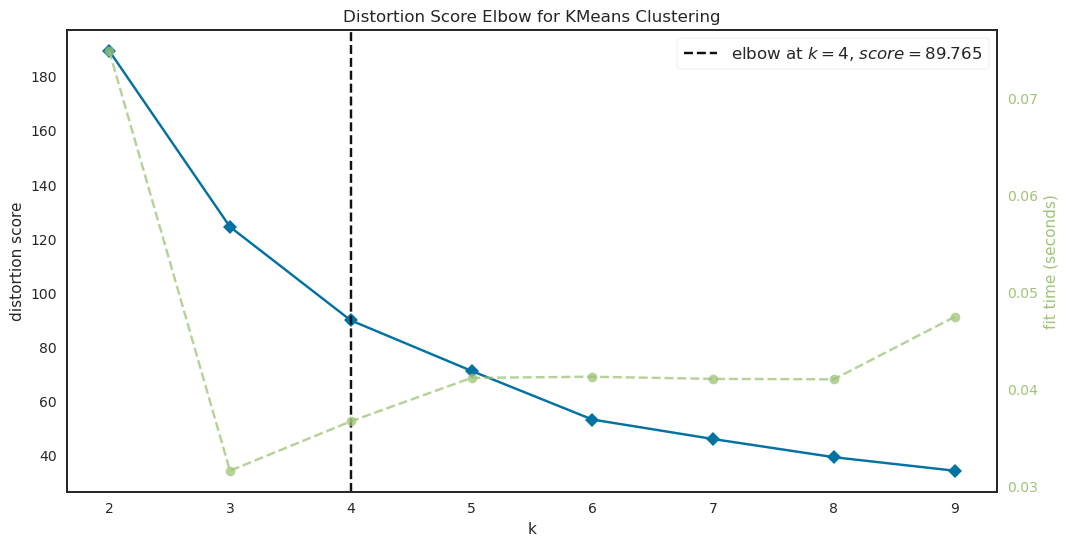

In [15]:
elbow_plot(X1)

**We can see that the optimal number of clusters is k=4.**

> # 2. Building the model

In [16]:
X1_model, X1_labels, X1_centroids = kmeans_model(4, X1)

> # **3. Visualizing the clusters**

<Figure size 800x550 with 0 Axes>

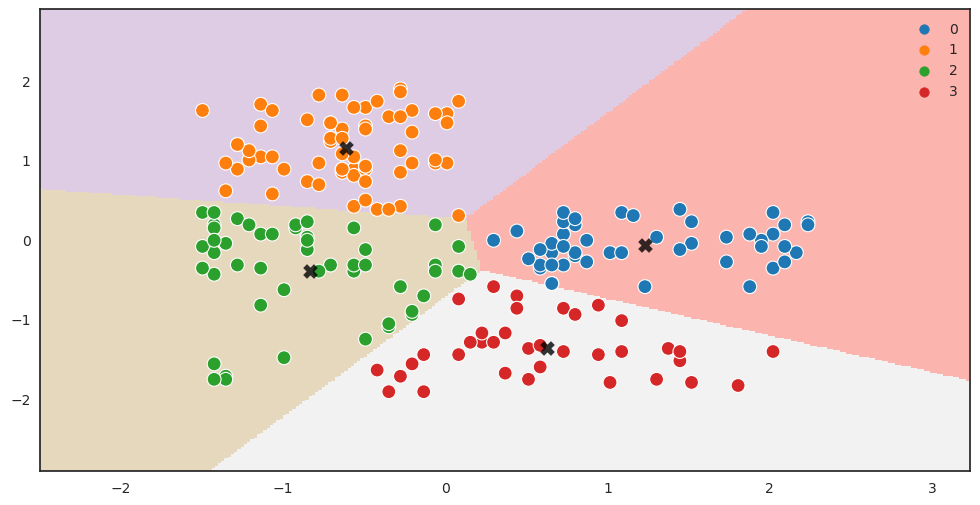

In [17]:
plot_clusters(X1, 0.02, X1_model, X1_labels, X1_centroids)

# Clustering for Age and Annual Income

> # 1. Elbow Plot

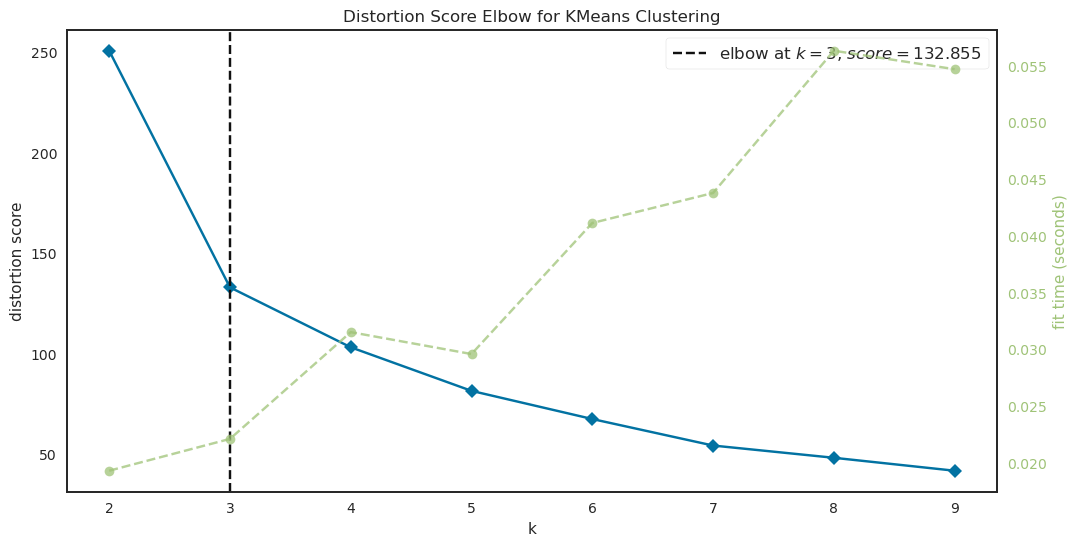

In [18]:
elbow_plot(X2)

**We can see that the optimal number of clusters is k=3.**

> # 2. Building the model

In [19]:
X2_model, X2_labels, X2_centroids = kmeans_model(3, X2)

> # 3. Visualizing the clusters

<Figure size 800x550 with 0 Axes>

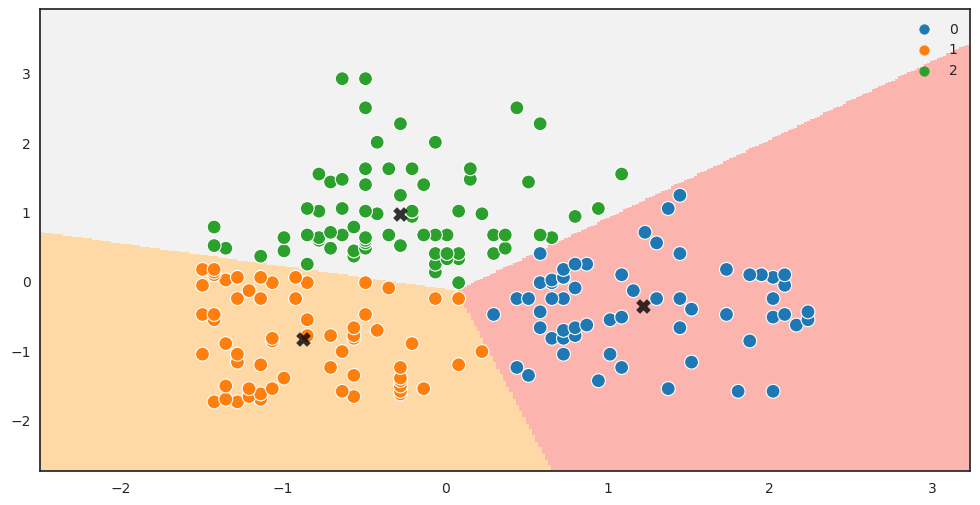

In [20]:
plot_clusters(X2, 0.02, X2_model, X2_labels, X2_centroids)

# Clustering for Annual Income and Spending Score

> # 1. Elbow Plot

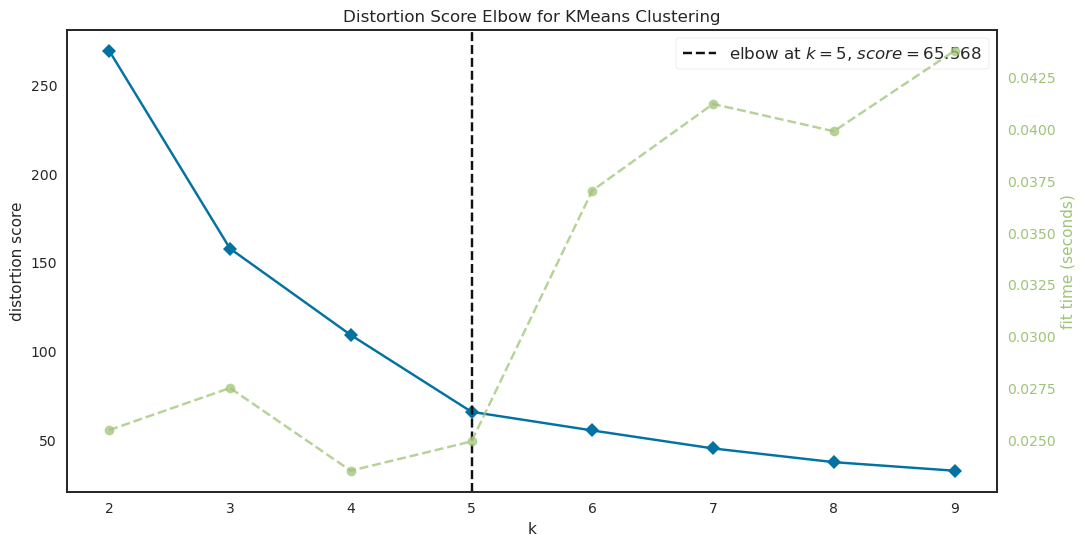

In [21]:
elbow_plot(X3)

**We can see that the optimal number of clusters is k=5**

> # 2. Building the model

In [22]:
X3_model, X3_labels, X3_centroids = kmeans_model(5, X3)

> # 3. Visualizing the clusters

<Figure size 800x550 with 0 Axes>

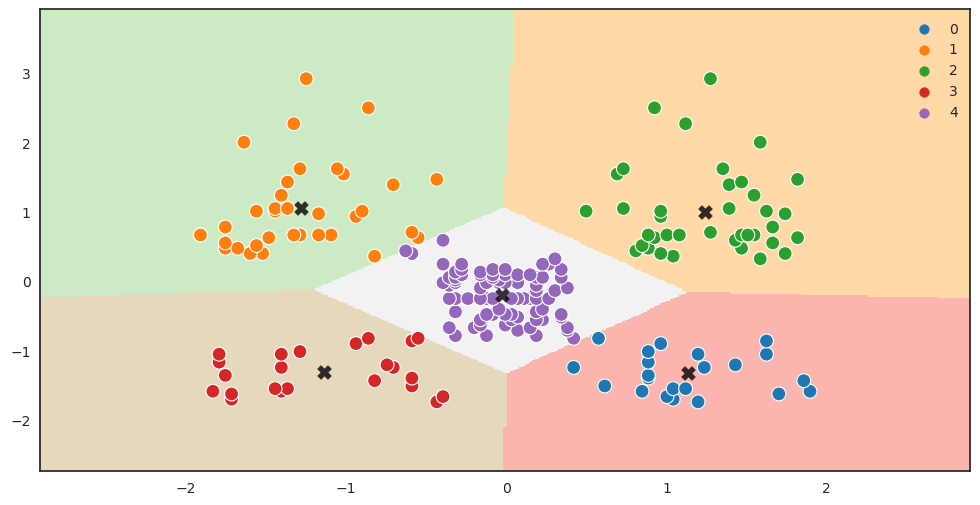

In [23]:
plot_clusters(X3, 0.02, X3_model, X3_labels, X3_centroids)

# Clustering for Age, Annual Income and Spending Score

> # 1. Applying PCA to reduce the data to 2 dimensions

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X = pca.fit_transform(X)

> # 2. Elbow Plot

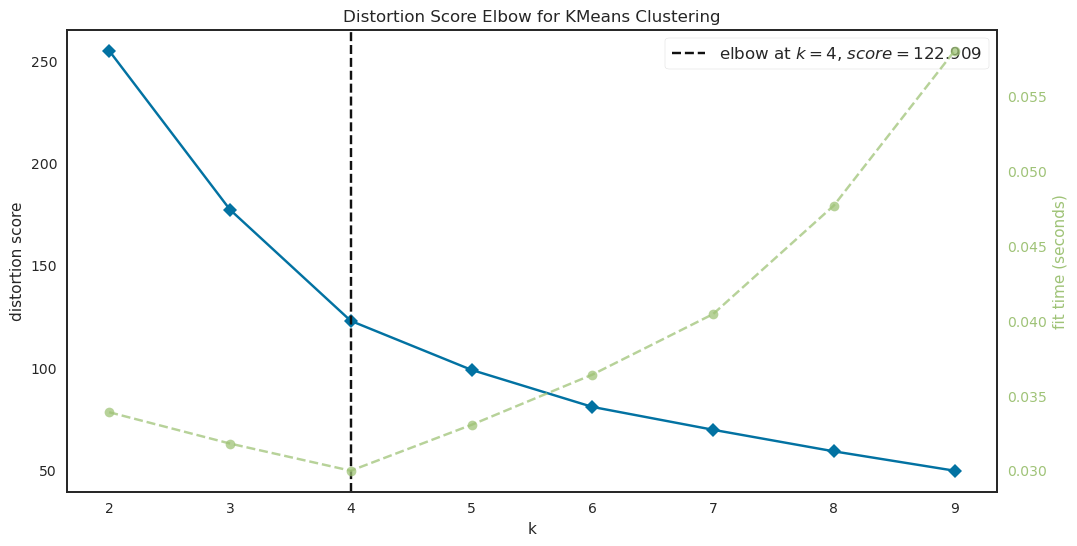

In [25]:
elbow_plot(X)

**We can see that the optimal number of clusters is k=4**

> # 2. Building the model

In [26]:
X_model, X_labels, X_centroids = kmeans_model(4, X)

> # 3. Visualizing the clusters

<Figure size 800x550 with 0 Axes>

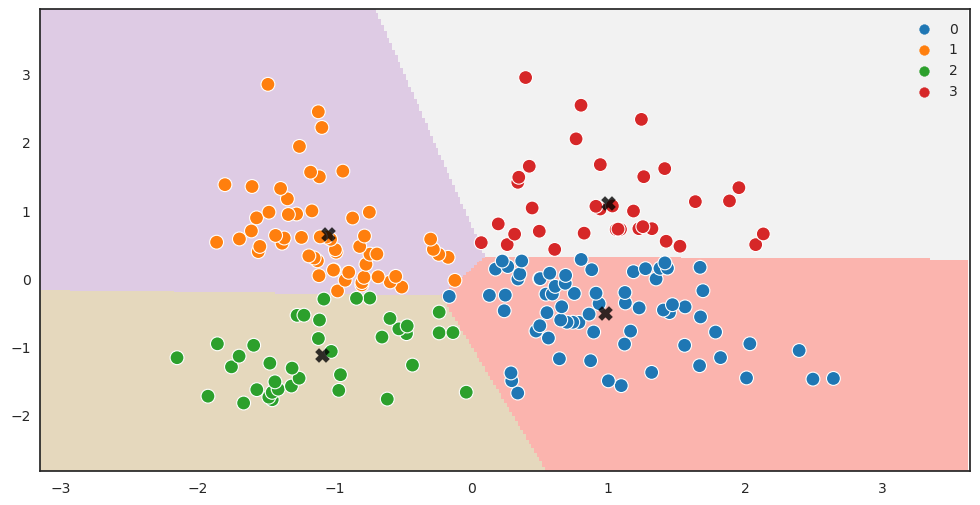

In [27]:
plot_clusters(X, 0.02, X_model, X_labels, X_centroids)

# Feel free to upvote, comment and suggest improvements.